In [1]:
!pip install -q -U autogluon.tabular ray

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.13.0 requires aiohttp<4.0.0,>=3.9.2, which is not installed.
s3fs 2024.3.1 requires aiohttp!=4.0.0a0,!=4.0.0a1, which is not installed.
aiobotocore 2.13.0 requires botocore<1.34.107,>=1.34.70, but you have botocore 1.29.165 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


# Imports and Configs

In [2]:
from autogluon.tabular import TabularPredictor, TabularDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil
import pickle
import glob
import os

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('husl')

In [3]:
TIME_LIMIT = 3600 * 10
N_FOLDS = 5
SEED = 27
TARGET = 'Target'

# Loading and Processing the Datasets

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [5]:
train = TabularDataset(train)
test = TabularDataset(test)

# Setting up K-Fold CV and Training

In [6]:
os.mkdir('test_preds')
os.mkdir('test_pred_probs')

In [7]:
skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)

histories = {}
oof_pred_probs = np.zeros((len(train), train[TARGET].nunique()))
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train.drop(columns=TARGET), train[TARGET])):
    _train, _val = train.iloc[train_idx], train.iloc[val_idx]    

    predictor = TabularPredictor(
        label=TARGET,
        eval_metric='accuracy',
        problem_type='multiclass',
        verbosity=2
    ).fit(
        train_data=_train,
        time_limit=TIME_LIMIT // N_FOLDS,
        excluded_model_types = ['KNN', 'NN', 'NN_TORCH', 'FASTAI'],
        presets='best_quality',
        save_space=True,
        ag_args_fit = {
            "stopping_metric": "log_loss",
        },
        feature_prune_kwargs={'force_prune': True}
    )
    
    fold_score = predictor.evaluate(_val, silent=True)['accuracy']
    
    pred_probs = predictor.predict_proba(_val)
    preds = pred_probs.idxmax(axis=1).values
    oof_pred_probs[val_idx] = pred_probs
    
    test_pred_probs = predictor.predict_proba(test)
    
    test_preds = test_pred_probs.idxmax(axis=1).values
    test_preds = pd.DataFrame({TARGET: test_preds}, index=test.index)
    test_preds.to_csv(f'test_preds/fold_{fold_idx}_test_preds_acc-{fold_score:.6f}.csv')
    
    test_pred_probs = pd.DataFrame(test_pred_probs, index=test.index)
    test_pred_probs.to_csv(f'test_pred_probs/fold_{fold_idx}_test_pred_probs_acc-{fold_score:.6f}.csv')
    
    histories[f'Fold {fold_idx}'] = {}
    histories[f'Fold {fold_idx}']['y'] = _val[TARGET].values
    histories[f'Fold {fold_idx}']['pred_probs'] = pred_probs
    histories[f'Fold {fold_idx}']['preds'] = preds
    histories[f'Fold {fold_idx}']['accuracy'] = fold_score
    histories[f'Fold {fold_idx}']['auc'] = roc_auc_score(_val[TARGET], pred_probs, multi_class='ovo')
    if fold_idx == 0:
        histories[f'Fold {fold_idx}']['leaderboard'] = predictor.leaderboard(_val, silent=True)
        histories[f'Fold {fold_idx}']['feature_importance'] = predictor.feature_importance(_val, silent=True)
    
    print(f'Fold {fold_idx} - Accuracy: {fold_score}')
    
    shutil.rmtree("AutogluonModels")
    del predictor

No path specified. Models will be saved in: "AutogluonModels/ag-20240611_181331"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240611_181331/ds_sub_fit/sub_fit_ho.
2024-06-11 18:13:32,250	INFO util.py:124 -- Outdated packages:
  ipywidgets==7

[1000]	valid_set's multi_logloss: 0.421558
[1000]	valid_set's multi_logloss: 0.429838
[1000]	valid_set's multi_logloss: 0.43493
[1000]	valid_set's multi_logloss: 0.429178
[1000]	valid_set's multi_logloss: 0.434032
[1000]	valid_set's multi_logloss: 0.434116
[1000]	valid_set's multi_logloss: 0.449545
[1000]	valid_set's multi_logloss: 0.448436


	0.8307	 = Validation score   (accuracy)
	362.31s	 = Training   runtime
	13.21s	 = Validation runtime
Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 1356.32s of the 3146.72s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1094.
	Ran out of time, early stopping on iteration 1116.
	Ran out of time, early stopping on iteration 1164.
	Ran out of time, early stopping on iteration 1193.
	Ran out of time, early stopping on iteration 1283.
	0.8314	 = Validation score   (accuracy)
	1204.55s	 = Training   runtime
	1.24s	 = Validation runtime
Fitting model: LightGBM_r96_BAG_L1 ... Training model for up to 150.11s of the 1940.51s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 550. Best iteration is:
	[550]	valid_set's multi_logloss: 0.444083
	Ran out of time, early stopping 

Fold 0 - Accuracy: 0.8343570308416101


No path specified. Models will be saved in: "AutogluonModels/ag-20240611_205827"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240611_205827/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models

[1000]	valid_set's multi_logloss: 0.429718
[1000]	valid_set's multi_logloss: 0.43608
[1000]	valid_set's multi_logloss: 0.446089
[1000]	valid_set's multi_logloss: 0.435823
[1000]	valid_set's multi_logloss: 0.428134
[1000]	valid_set's multi_logloss: 0.434087
[1000]	valid_set's multi_logloss: 0.447023
[1000]	valid_set's multi_logloss: 0.434949


	0.8312	 = Validation score   (accuracy)
	357.11s	 = Training   runtime
	12.9s	 = Validation runtime
Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 1295.04s of the 3086.34s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1055.
	Ran out of time, early stopping on iteration 1095.
	Ran out of time, early stopping on iteration 1110.
	Ran out of time, early stopping on iteration 1173.
	Ran out of time, early stopping on iteration 1219.
	Ran out of time, early stopping on iteration 1296.
	0.8307	 = Validation score   (accuracy)
	1219.8s	 = Training   runtime
	1.28s	 = Validation runtime
Fitting model: LightGBM_r96_BAG_L1 ... Training model for up to 73.54s of the 1864.84s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 256. Best iteration is:
	[256]	valid_set's multi_lo

Fold 1 - Accuracy: 0.8343570308416101


No path specified. Models will be saved in: "AutogluonModels/ag-20240611_230603"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240611_230603/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models

[1000]	valid_set's multi_logloss: 0.432834
[1000]	valid_set's multi_logloss: 0.433748
[1000]	valid_set's multi_logloss: 0.440159
[1000]	valid_set's multi_logloss: 0.450802
[1000]	valid_set's multi_logloss: 0.426249
[1000]	valid_set's multi_logloss: 0.434762
[1000]	valid_set's multi_logloss: 0.425336
[1000]	valid_set's multi_logloss: 0.440034


	0.8312	 = Validation score   (accuracy)
	347.05s	 = Training   runtime
	12.88s	 = Validation runtime
Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 3279.54s of the 3279.49s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8312	 = Validation score   (accuracy)
	1398.47s	 = Training   runtime
	1.2s	 = Validation runtime
Fitting model: LightGBM_r96_BAG_L1 ... Training model for up to 1879.47s of the 1879.42s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's multi_logloss: 0.440197
[2000]	valid_set's multi_logloss: 0.434337
[3000]	valid_set's multi_logloss: 0.432835
[4000]	valid_set's multi_logloss: 0.432775
[1000]	valid_set's multi_logloss: 0.442124
[2000]	valid_set's multi_logloss: 0.436623
[3000]	valid_set's multi_logloss: 0.435683
[4000]	valid_set's multi_logloss: 0.435864
[1000]	valid_set's multi_logloss: 0.450261
[2000]	valid_set's multi_logloss: 0.444189
[3000]	valid_set's multi_logloss: 0.44251
[4000]	valid_set's multi_logloss: 0.441966
[5000]	valid_set's multi_logloss: 0.442139
[1000]	valid_set's multi_logloss: 0.461169
[2000]	valid_set's multi_logloss: 0.453513
[3000]	valid_set's multi_logloss: 0.451404
[4000]	valid_set's multi_logloss: 0.450894
[5000]	valid_set's multi_logloss: 0.450995
[1000]	valid_set's multi_logloss: 0.434137
[2000]	valid_set's multi_logloss: 0.428682
[3000]	valid_set's multi_logloss: 0.427363
[4000]	valid_set's multi_logloss: 0.427217
[1000]	valid_set's multi_logloss: 0.445068
[2000]	valid

	0.8297	 = Validation score   (accuracy)
	881.07s	 = Training   runtime
	43.14s	 = Validation runtime
Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 950.26s of the 950.21s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8303	 = Validation score   (accuracy)
	278.12s	 = Training   runtime
	18.73s	 = Validation runtime
Fitting model: ExtraTrees_r42_BAG_L1 ... Training model for up to 651.28s of the 651.23s of remaining time.
	0.8231	 = Validation score   (accuracy)
	30.46s	 = Training   runtime
	4.09s	 = Validation runtime
Fitting model: CatBoost_r137_BAG_L1 ... Training model for up to 614.86s of the 614.81s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 2004.
	Ran out of time, early stopping on iteration 2073.
	Ran out of time, early stopping on iteration 2128.
	Ran out of time, early stopping on iteratio

Fold 2 - Accuracy: 0.8348144276006273


No path specified. Models will be saved in: "AutogluonModels/ag-20240612_012020"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240612_012020/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models

[1000]	valid_set's multi_logloss: 0.440149
[1000]	valid_set's multi_logloss: 0.433738
[1000]	valid_set's multi_logloss: 0.435225
[1000]	valid_set's multi_logloss: 0.428308
[1000]	valid_set's multi_logloss: 0.425285
[2000]	valid_set's multi_logloss: 0.425461
[1000]	valid_set's multi_logloss: 0.438628
[1000]	valid_set's multi_logloss: 0.430343
[1000]	valid_set's multi_logloss: 0.438235


	0.8315	 = Validation score   (accuracy)
	368.11s	 = Training   runtime
	13.76s	 = Validation runtime
Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 1250.86s of the 3040.71s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1006.
	Ran out of time, early stopping on iteration 1054.
	Ran out of time, early stopping on iteration 1088.
	Ran out of time, early stopping on iteration 1130.
	Ran out of time, early stopping on iteration 1174.
	Ran out of time, early stopping on iteration 1254.
	Ran out of time, early stopping on iteration 1374.
	0.8312	 = Validation score   (accuracy)
	1186.56s	 = Training   runtime
	1.23s	 = Validation runtime
Fitting model: LightGBM_r96_BAG_L1 ... Training model for up to 62.66s of the 1852.5s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteratio

Fold 3 - Accuracy: 0.833300660001307


No path specified. Models will be saved in: "AutogluonModels/ag-20240612_032754"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240612_032754/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models

[1000]	valid_set's multi_logloss: 0.441736
[1000]	valid_set's multi_logloss: 0.43183
[1000]	valid_set's multi_logloss: 0.432781
[1000]	valid_set's multi_logloss: 0.444861
[1000]	valid_set's multi_logloss: 0.423603
[1000]	valid_set's multi_logloss: 0.425869
[1000]	valid_set's multi_logloss: 0.419879
[2000]	valid_set's multi_logloss: 0.419934
[1000]	valid_set's multi_logloss: 0.421072


	0.8339	 = Validation score   (accuracy)
	370.25s	 = Training   runtime
	13.48s	 = Validation runtime
Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 3075.0s of the 3074.96s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8325	 = Validation score   (accuracy)
	1403.09s	 = Training   runtime
	1.2s	 = Validation runtime
Fitting model: LightGBM_r96_BAG_L1 ... Training model for up to 1670.3s of the 1670.25s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's multi_logloss: 0.449325
[2000]	valid_set's multi_logloss: 0.444505
[3000]	valid_set's multi_logloss: 0.443936
[1000]	valid_set's multi_logloss: 0.444296
[2000]	valid_set's multi_logloss: 0.437015
[3000]	valid_set's multi_logloss: 0.434638
[4000]	valid_set's multi_logloss: 0.433863
[5000]	valid_set's multi_logloss: 0.433497
[6000]	valid_set's multi_logloss: 0.433588
[7000]	valid_set's multi_logloss: 0.434234
[1000]	valid_set's multi_logloss: 0.439378
[2000]	valid_set's multi_logloss: 0.434651
[3000]	valid_set's multi_logloss: 0.433329
[4000]	valid_set's multi_logloss: 0.433323
[1000]	valid_set's multi_logloss: 0.455225
[2000]	valid_set's multi_logloss: 0.448506
[3000]	valid_set's multi_logloss: 0.446504
[4000]	valid_set's multi_logloss: 0.446099
[5000]	valid_set's multi_logloss: 0.446384
[1000]	valid_set's multi_logloss: 0.435974
[2000]	valid_set's multi_logloss: 0.42776
[3000]	valid_set's multi_logloss: 0.424876
[4000]	valid_set's multi_logloss: 0.423853
[5000]	valid

	0.8324	 = Validation score   (accuracy)
	963.83s	 = Training   runtime
	52.72s	 = Validation runtime
Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 648.01s of the 647.96s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.8328	 = Validation score   (accuracy)
	280.57s	 = Training   runtime
	19.72s	 = Validation runtime
Fitting model: ExtraTrees_r42_BAG_L1 ... Training model for up to 345.63s of the 345.59s of remaining time.
	0.8266	 = Validation score   (accuracy)
	32.72s	 = Training   runtime
	4.43s	 = Validation runtime
Fitting model: CatBoost_r137_BAG_L1 ... Training model for up to 306.71s of the 306.66s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 990.
	Ran out of time, early stopping on iteration 1044.
	Ran out of time, early stopping on iteration 1074.
	Ran out of time, early stopping on iteration

Fold 4 - Accuracy: 0.826112526955499


In [8]:
with open('ag_oof_pred_probs.pkl', 'wb') as f:
    pickle.dump(oof_pred_probs, f)

In [9]:
mappings = {v: k for k, v in enumerate(histories['Fold 0']['pred_probs'].columns)}
reverse_mappings = {v: k for k, v in mappings.items()}

In [10]:
histories['All'] = {}
histories['All']['accuracy'] = accuracy_score(train[TARGET].map(mappings), oof_pred_probs.argmax(axis=1))
histories['All']['auc'] = roc_auc_score(train[TARGET], oof_pred_probs, multi_class='ovo')
histories['All']['pred_probs'] = oof_pred_probs
histories['All']['preds'] = oof_pred_probs.argmax(axis=1)
histories['All']['y'] = train[TARGET].values

# Visualizing the Results

In [11]:
histories['Fold 0']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestEntr_BAG_L2,0.836513,0.830660,accuracy,97.485745,55.969374,3579.104837,2.446287,4.767835,72.260585,2,True,19
1,LightGBM_r131_BAG_L1,0.835925,0.830725,accuracy,33.518901,13.211861,362.307242,33.518901,13.211861,362.307242,1,True,11
2,LightGBMXT_BAG_L2,0.835925,0.831574,accuracy,97.019768,52.138539,3609.946363,1.980310,0.937000,103.102111,2,True,16
3,LightGBM_BAG_L1,0.835664,0.830268,accuracy,5.281281,2.602475,86.205395,5.281281,2.602475,86.205395,1,True,2
4,CatBoost_r177_BAG_L2,0.835664,0.831052,accuracy,95.235608,51.347271,3749.547891,0.196150,0.145732,242.703639,2,True,25
5,LightGBMLarge_BAG_L2,0.835664,0.830937,accuracy,98.302522,52.692123,3702.833856,3.263064,1.490584,195.989604,2,True,24
6,WeightedEnsemble_L3,0.835599,0.832473,accuracy,110.837198,69.317431,4456.223516,0.010581,0.009128,4.388192,3,True,28
7,LightGBM_r131_BAG_L2,0.835533,0.831019,accuracy,104.355356,55.554006,3824.147398,9.315898,4.352467,317.303146,2,True,26
8,ExtraTreesGini_BAG_L2,0.835272,0.830415,accuracy,97.040768,56.474394,3523.247571,2.001309,5.272855,16.403319,2,True,21
9,LightGBM_BAG_L2,0.835141,0.831558,accuracy,96.505460,51.925451,3607.886063,1.466001,0.723912,101.041811,2,True,17


In [12]:
histories['Fold 0']['feature_importance'].style.background_gradient(subset=['importance'], cmap='RdYlGn')

,importance,stddev,p_value,n,p99_high,p99_low
Curricular units 2nd sem (approved),0.196640,0.006882,0.000000,5,0.210811,0.182469
Tuition fees up to date,0.039560,0.001699,0.000000,5,0.043059,0.036061
Curricular units 1st sem (approved),0.023280,0.004365,0.000142,5,0.032267,0.014293
Scholarship holder,0.008640,0.001946,0.000289,5,0.012647,0.004633
Curricular units 2nd sem (evaluations),0.007240,0.002027,0.000666,5,0.011413,0.003067
Curricular units 2nd sem (grade),0.005920,0.003074,0.006294,5,0.012250,-0.000410
Curricular units 2nd sem (enrolled),0.005000,0.002909,0.009199,5,0.010989,-0.000989
Course,0.003320,0.001973,0.009862,5,0.007382,-0.000742
Curricular units 1st sem (grade),0.003280,0.002773,0.028656,5,0.008991,-0.002431
Age at enrollment,0.003240,0.001417,0.003461,5,0.006158,0.000322


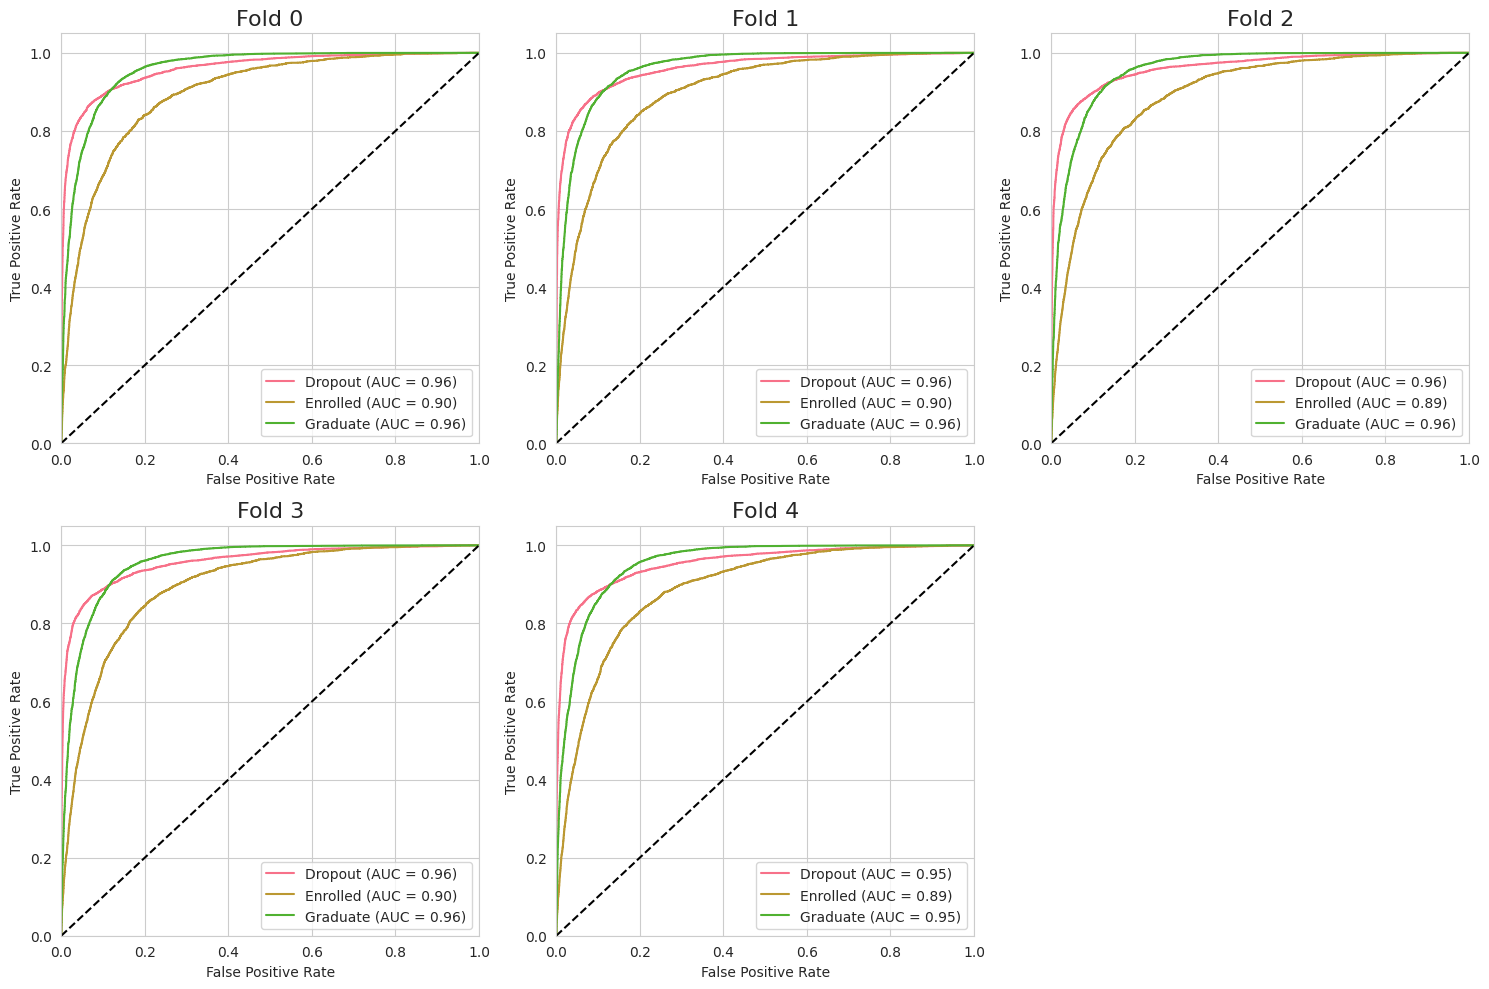

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    pred_probs = histories[f'Fold {fold_idx}']['pred_probs']
    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    preds = np.array([mappings[p] for p in preds])
    y = np.array([mappings[p] for p in y])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(pred_probs.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y == i, pred_probs.values[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(pred_probs.shape[1]):
        ax.plot(fpr[i], tpr[i], label=f'{reverse_mappings[i]} (AUC = {roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Fold {fold_idx}', fontsize=16)
    ax.legend()

plt.tight_layout()
plt.show()

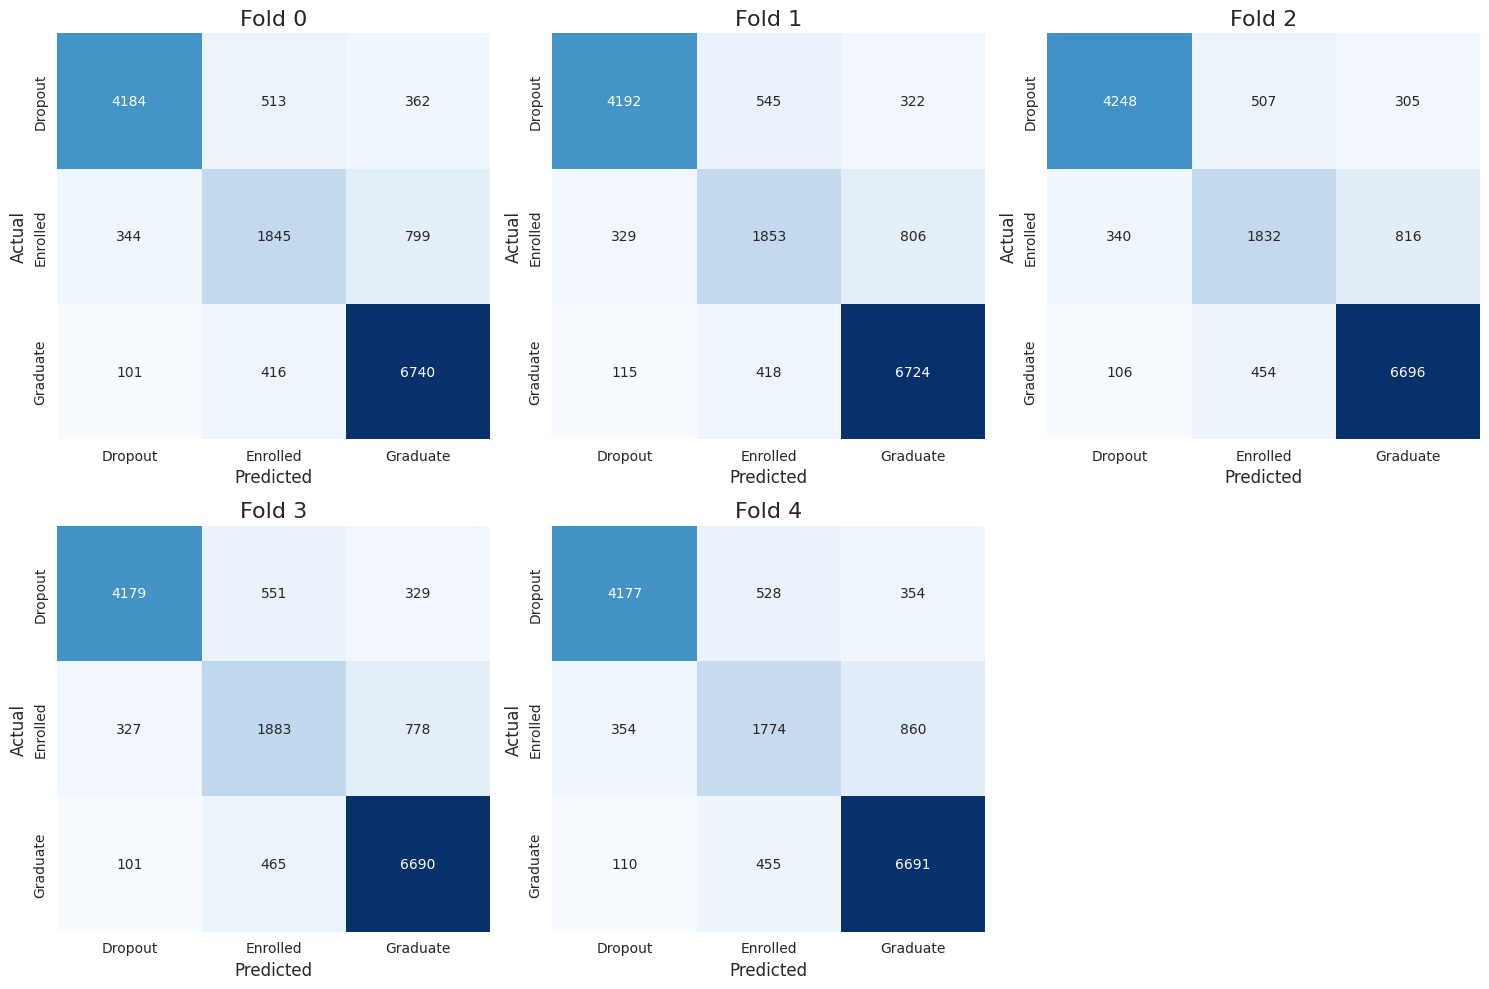

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    preds = np.array([mappings[p] for p in preds])
    y = np.array([mappings[p] for p in y])

    cm = confusion_matrix(y, preds)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        ax=ax,
        cmap='Blues',
        cbar=False,
        xticklabels=reverse_mappings.values(),
        yticklabels=reverse_mappings.values()
    )

    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(f'Fold {fold_idx}', fontsize=16)

plt.tight_layout()
plt.show()

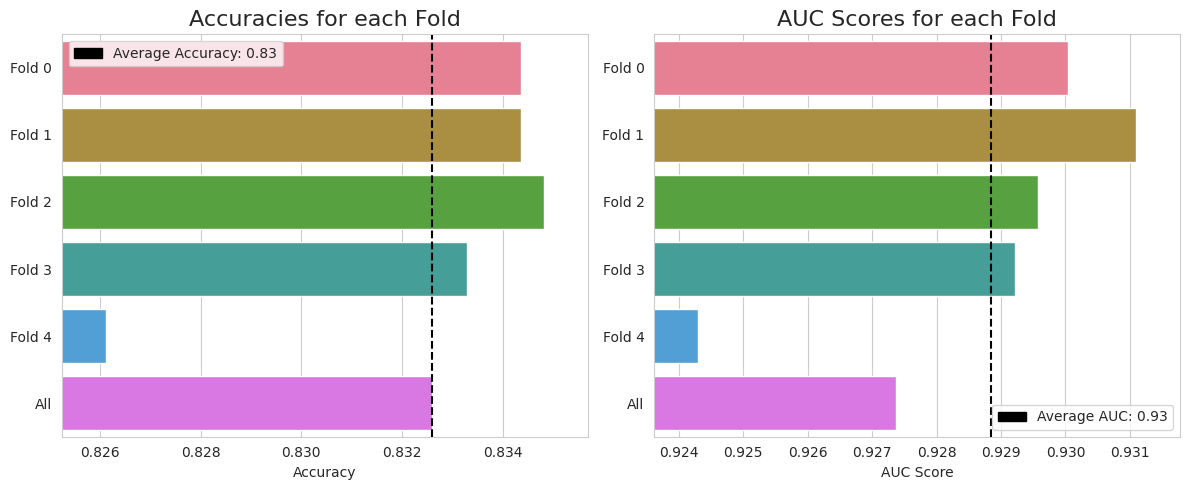

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

accuracies = [histories[f'Fold {i}']['accuracy'] for i in range(N_FOLDS)]
mean_accuracy = np.mean(accuracies)
accuracies = accuracies + [histories['All']['accuracy']]

min_acc = min(accuracies)
max_acc = max(accuracies)
acc_padding = (max_acc - min_acc) * 0.1
acc_lower_limit = min_acc - acc_padding
acc_upper_limit = max_acc + acc_padding

sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=accuracies, ax=axs[0], palette='husl', orient='h')
axs[0].axvline(mean_accuracy, color='black', linestyle='--')
axs[0].set_xlim(left=acc_lower_limit, right=acc_upper_limit)
axs[0].set_xlabel('Accuracy')
axs[0].set_title('Accuracies for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='black', label=f'Average Accuracy: {mean_accuracy:.2f}')
axs[0].legend(handles=[blue_patch], loc='best')


auc_scores = [histories[f'Fold {i}']['auc'] for i in range(N_FOLDS)]
mean_auc = np.mean(auc_scores)
auc_scores = auc_scores + [histories['All']['auc']]

min_auc = min(auc_scores)
max_auc = max(auc_scores)
auc_padding = (max_auc - min_auc) * 0.1
auc_lower_limit = min_auc - auc_padding
auc_upper_limit = max_auc + auc_padding

sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=auc_scores, ax=axs[1], palette='husl', orient='h')
axs[1].axvline(mean_auc, color='black', linestyle='--')
axs[1].set_xlim(left=auc_lower_limit, right=auc_upper_limit)
axs[1].set_xlabel('AUC Score')
axs[1].set_title('AUC Scores for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='black', label=f'Average AUC: {mean_auc:.2f}')
axs[1].legend(handles=[blue_patch], loc='best')

plt.tight_layout()
plt.show()

# Post-Processing and Inference

In [16]:
oof_files = glob.glob('test_pred_probs/fold_*_test_pred_probs_*.csv')
submissions = [pd.read_csv(f, index_col='id') for f in oof_files]

submission = pd.concat(submissions, axis=1)
submission = submission.groupby(level=0, axis=1).mean()

with open('ag_test_pred_probs.pkl', 'wb') as f:
    pickle.dump(submission.values, f)

submission['Target'] = submission.idxmax(axis=1)
submission['id'] = submission.index
submission = submission[['id', 'Target']]

submission.to_csv(f'ag_acc-{mean_accuracy:.6f}_auc-{mean_auc:.6f}.csv', index=False)
submission.head()

,id,Target
id,,
76518,76518,Dropout
76519,76519,Graduate
76520,76520,Graduate
76521,76521,Graduate
76522,76522,Enrolled
